In [21]:
%matplotlib notebook

In [31]:
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import numpy as np
from numpy import nan
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines
from shapely.geometry.polygon import Polygon

<IPython.core.display.Javascript object>


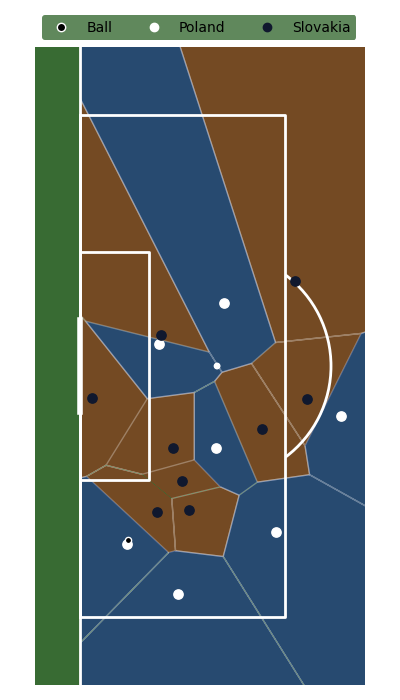

In [32]:
# Global Variables
FILE_PATH = 'PolandSlovakia.csv'
PITCH_COLOR = '#386b33'
TEAM1, TEAM2 = ['Poland', 'Slovakia']
TEAM1_VORONOI_COLOR, TEAM2_VORONOI_COLOR = ['red', 'blue']
VORONOI_EDGE_COLOR = 'w'
TEAM1_PLAYER_COLOR, TEAM2_PLAYER_COLOR = ['w', '#10182e'] # [team1, team2]
BALL_SIZE, PLAYER_SIZE = [20, 45] #Circle size 
BALL_COLOR, BALL_EDGE_COLOR = ['k', 'w']
ANIMATION_INTERVAL = 1000


#Load data
data = pd.read_csv(FILEPATH)

#Pitch
pitch = Pitch(pitch_type='statsbomb',pitch_color= PITCH_COLOR, line_color='white', pad_right = -95
              , pad_bottom=-12, pad_top = -12, goal_alpha=1,)


# Animation Function
def animate_voronoi(data):
    frames = [data.loc[data['Frame'] == n_frame] for n_frame in data['Frame'].unique()]
    team1_list = []
    team2_list = []
    ball_list = []

    for frame in frames:
        team1_new_row = []
        team2_new_row = []
        for i,row in frame.iterrows():
            if row['Team'] == TEAM1:
                team1_new_row.append((row['X'], row['Y'])) 
            elif row['Team'] == TEAM2:
                team2_new_row.append((row['X'], row['Y']))
            else:
                ball_list.append((row['X'], row['Y']))  
        team1_list.append(team1_new_row)
        team2_list.append(team2_new_row)

    lists = [team1_list, team2_list, ball_list]

    def init():
        team1_scatter.set_offsets([[], []])
        team2_scatter.set_offsets([[], []])
        ball_scatter.set_offsets([[], []])
        paths = [team1_scatter, team2_scatter, ball_scatter, team1_patch,  team2_patch]
        return paths

    def update(i, paths, lists):
        team1_scatter, team2_scatter, ball_scatter, team1_patch, team2_patch = paths  
        team1_list, team2_list, ball_list = lists
        team1_scatter.set_offsets(team1_list[i])
        team2_scatter.set_offsets(team2_list[i])
        ball_scatter.set_offsets(ball_list[i])
        team1_poly, team2_poly = team1_poly_list[i], team2_poly_list[i] 
        stoppoint = np.array([[nan,nan]]) 
        team1_voronoi = np.concatenate((team1_poly[0], stoppoint, team1_poly[1]))
        for poly in team1_poly[2:]:  
                team1_voronoi = np.concatenate((team1_voronoi, stoppoint, poly))
        team1_patch.set_xy(team1_voronoi)

        team2_voronoi = np.concatenate((team2_poly[0], stoppoint, team2_poly[1]))
        for poly in team2_poly[2:]:  
                team2_voronoi = np.concatenate((team2_voronoi, stoppoint, poly))
        team2_patch.set_xy(team2_voronoi)
        paths = [team1_scatter, team2_scatter, ball_scatter, team1_patch,  team2_patch]
        return paths

    pts = [(0,0), (10,15), (23,3)]
    fig, ax = pitch.draw()
    fig.set_size_inches(4, 7)
    team1_scatter = plt.scatter([], [], s=PLAYER_SIZE, c = TEAM1_PLAYER_COLOR)
    team2_scatter = plt.scatter([], [], s=PLAYER_SIZE, c = TEAM2_PLAYER_COLOR)
    ball_scatter = plt.scatter([], [], s=BALL_SIZE, c=BALL_COLOR, edgecolor=BALL_EDGE_COLOR)
    team1_patch = patches.Polygon(pts,closed=True, fc = TEAM1_VORONOI_COLOR, ec=VORONOI_EDGE_COLOR, alpha = 0.3, zorder = 0)
    team2_patch = patches.Polygon(pts,closed=True, fc = TEAM2_VORONOI_COLOR, ec=VORONOI_EDGE_COLOR, alpha = 0.3, zorder = 0)
    paths = [team1_scatter, team2_scatter, ball_scatter, team1_patch, team2_patch]

    ax.add_patch(team1_patch)
    ax.add_patch(team2_patch)


    team1_poly_list, team2_poly_list = [], []
    for i in range(len(team1_list)):
        x = []
        y = []
        for lst in lists[:2]:
            for point in lst[i]:
                x.append(point[0])
                y.append(point[1]) 
        zeros = [0] * len(team1_list[i])
        ones = [1] * len(team2_list[i])
        team1_poly, team2_poly = pitch.voronoi(x, y, zeros+ones)  
        team1_poly_list.append(team1_poly)
        team2_poly_list.append(team2_poly)

    anim = animation.FuncAnimation(
        fig, update, init_func=init, fargs=(paths, lists), interval=ANIMATION_INTERVAL, frames=len(frames), 
        blit=True, repeat=True)
    mBall = mlines.Line2D([], [], markeredgecolor='w', markerfacecolor = 'k', marker="o", ls='', label='Ball')
    mTeam1 = mlines.Line2D([], [], color=PALETTE[0], marker="o", ls='', label=TEAM1)
    mTeam2 = mlines.Line2D([], [], color=PALETTE[1], marker="o", ls='', label=TEAM2)
    legend = plt.legend(handles=[mBall, mTeam1, mTeam2], facecolor = PITCH_COLOR, ncol = 3,edgecolor= 'none',
                        bbox_to_anchor = (0.0, 1), loc='lower left')
    return anim

animate_voronoi(data)

### Adding Interpolated Frames: Enhancing Animation Fluidity and Trajectory Visualization

We successfully generated an animation of the play; however, we encountered an issue with its fluidity. The ball and players appear to teleport between frames, compromising the overall visual experience. In order to enhance this visualization, our approach involves filling the gaps between frames, allowing for a clear depiction of the trajectory of each player and the ball. To achieve this, we utilize the 'interpolate_df' function from the 'interpolation.py' file.

<IPython.core.display.Javascript object>


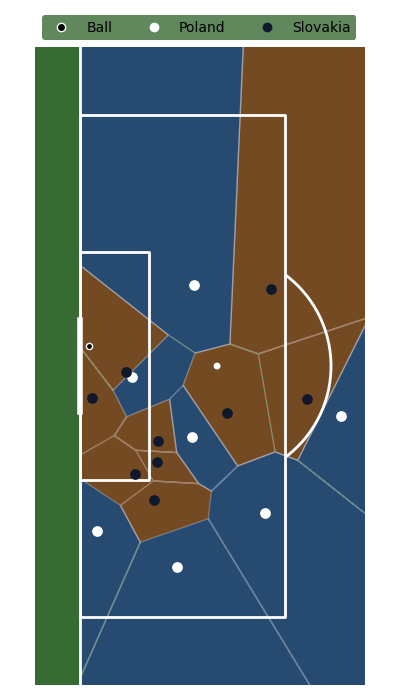

In [33]:
from interpolation import interpolate_df
n_frames_inbetween = 100
ANIMATION_INTERVAL = ANIMATION_INTERVAL/n_frames_inbetween
interpolated_data = interpolate_df(data, n_frames_inbetween)
animate_voronoi(interpolated_data)